In [1]:
#
# Libraries
#
import datetime
import dateutil.relativedelta
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
#from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from shapely import geometry
from shapely.geometry import Point, Polygon, LineString
import shapely.wkt
from geopandas.tools import sjoin
import sys
print("Python version", sys.version)
print ("Version info.", sys.version_info, sys.executable)
from datetime import datetime
import zipfile
import shutil
import rasterio
from rasterio.plot import show
from matplotlib import pyplot
import pycrs
from skimage import filters
from skimage import exposure
from skimage.feature import greycomatrix, greycoprops
from skimage import data
from osgeo import ogr
from osgeo import gdal
import plotly
import requests
import skimage
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from mpl_toolkits import mplot3d

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

C:\Anaconda3\envs\geo37\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Python version 3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
Version info. sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0) C:\Anaconda3\envs\geo37\python.exe


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
data_path = 'C:/Users/mhudgell/data/dsa-jake/'
os.listdir(data_path)
file_path = data_path +'1 Team & Station Trip Level Data - April 2024 - Randomised.csv'
trip = pd.read_csv(file_path)

In [4]:
real_trip = trip[(trip['Hours'] >= 0.0)] #0.4
real_trip['end_ts']  = pd.to_datetime(real_trip['Date'] + ' ' + real_trip['Time - End'])
real_trip['start_ts']  = pd.to_datetime(real_trip['Date'] + ' ' + real_trip['Time - Start'])
real_trip['dow'] = real_trip['end_ts'].dt.weekday
real_trip['label'] = real_trip['end_ts'].dt.hour
real_trip['start_hour'] = real_trip['start_ts'].dt.hour
real_trip['start_min'] = real_trip['start_ts'].dt.minute


In [5]:
real_trip.head(10)

,Registration,Fleet,Vehicle Function,Station,Date,Time - Start,Time - End,Trip Count,Miles Travelled,Hours,Speed,end_ts,start_ts,dow,label,start_hour,start_min
0,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,00:36:19,01:16:04,1,2.49,0.66,3.77,2024-04-01 01:16:04,2024-04-01 00:36:19,0,1,0,36
1,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,02:23:22,02:30:37,1,2.30,0.12,19.17,2024-04-01 02:30:37,2024-04-01 02:23:22,0,2,2,23
2,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,03:24:11,03:32:05,1,2.24,0.13,17.23,2024-04-01 03:32:05,2024-04-01 03:24:11,0,3,3,24
3,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,03:48:21,03:54:24,1,1.93,0.10,19.30,2024-04-01 03:54:24,2024-04-01 03:48:21,0,3,3,48
4,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,03:59:36,05:46:48,1,37.97,1.79,21.21,2024-04-01 05:46:48,2024-04-01 03:59:36,0,5,3,59
5,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,10:02:54,10:12:15,1,2.11,0.16,13.19,2024-04-01 10:12:15,2024-04-01 10:02:54,0,10,10,2
6,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,10:27:19,10:52:46,1,8.14,0.42,19.38,2024-04-01 10:52:46,2024-04-01 10:27:19,0,10,10,27
7,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,11:12:26,11:17:59,1,1.43,0.09,15.89,2024-04-01 11:17:59,2024-04-01 11:12:26,0,11,11,12
8,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,11:33:57,11:53:06,1,5.66,0.32,17.69,2024-04-01 11:53:06,2024-04-01 11:33:57,0,11,11,33
9,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,12:30:13,12:32:25,1,0.68,0.04,17.00,2024-04-01 12:32:25,2024-04-01 12:30:13,0,12,12,30


In [6]:
data_df = real_trip[['Registration', 'Fleet', 'Vehicle Function', 'Station', 'Date', 'start_ts', 'dow', 'start_hour', 'start_min', 'label']]

In [7]:
data_df.head(10)

,Registration,Fleet,Vehicle Function,Station,Date,start_ts,dow,start_hour,start_min,label
0,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 00:36:19,0,0,36,1
1,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 02:23:22,0,2,23,2
2,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 03:24:11,0,3,24,3
3,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 03:48:21,0,3,48,3
4,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 03:59:36,0,3,59,5
5,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 10:02:54,0,10,2,10
6,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 10:27:19,0,10,27,10
7,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 11:12:26,0,11,12,11
8,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 11:33:57,0,11,33,11
9,111111,South Worcestershire,PATROL,WORCESTER,01-Apr-24,2024-04-01 12:30:13,0,12,30,12


In [8]:
one_hot_encoded_data = pd.get_dummies(data_df, columns = ['Registration', 'Fleet', 'Vehicle Function', 'Station'])
                    


In [9]:
list(one_hot_encoded_data.columns)

['Date',
 'start_ts',
 'dow',
 'start_hour',
 'start_min',
 'label',
 'Registration_111111',
 'Registration_222222',
 'Registration_333333',
 'Registration_444444',
 'Registration_555555',
 'Registration_666666',
 'Registration_777777',
 'Registration_888888',
 'Registration_999999',
 'Registration_AAAAAA',
 'Registration_BBBBBB',
 'Registration_CCCCCC',
 'Registration_DDDDDD',
 'Registration_EEEEEE',
 'Registration_FFFFFF',
 'Fleet_South Worcestershire',
 'Vehicle Function_PATROL',
 'Station_WORCESTER']

In [10]:
features_of_interest = ['start_hour', 'start_min', 'dow', 'Registration_111111', 'Registration_222222','Registration_333333', 'Registration_444444', 
                        'Registration_555555', 'Registration_666666', 'Registration_777777', 'Registration_888888', 'Registration_999999', 
                        'Registration_AAAAAA', 'Registration_BBBBBB', 'Registration_CCCCCC', 'Registration_DDDDDD', 'Registration_EEEEEE', 
                        'Fleet_South Worcestershire', 'Vehicle Function_PATROL', 'Station_WORCESTER']

In [11]:
feature_df = one_hot_encoded_data[features_of_interest].copy()
label_df = one_hot_encoded_data['label'].copy()
features = feature_df.to_numpy()
labels = label_df.to_numpy()
print(labels.shape)
print(features.shape)

(5108,)
(5108, 20)


<AxesSubplot:>

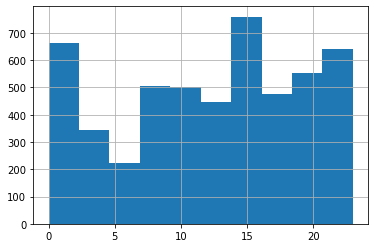

In [12]:
label_df.hist()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, shuffle=True, stratify=None)

In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3831, 20)
(1277, 20)
(3831,)
(1277,)


In [17]:
RF_Model = RandomForestRegressor(n_estimators=1000, verbose=1, bootstrap=False, n_jobs=4)#, random_state = 21)
RF_Model.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.2s finished


RandomForestRegressor(bootstrap=False, n_estimators=1000, n_jobs=4, verbose=1)

In [18]:
y_predict = RF_Model.predict(x_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [19]:
RF_Model.score(x_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.880499588497907

In [20]:
print(RF_Model.feature_importances_)

[8.81692693e-01 7.35135915e-02 1.86076530e-02 5.10622809e-03
 5.20884132e-05 3.05235725e-06 1.37689553e-03 1.20966188e-03
 4.11478397e-03 2.07173445e-03 2.34685400e-03 1.37779610e-03
 6.75801635e-05 2.90719103e-03 3.84416416e-03 7.51932827e-05
 1.63283948e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [24]:
y_test.shape

(1277,)

In [25]:
y_predict.shape

(1277,)

In [26]:
x_test.shape

(1277, 20)

In [27]:
df = pd.DataFrame(x_test, columns =features_of_interest) 
df1 = pd.DataFrame(y_predict, columns =['prediction']) 
df2 = pd.DataFrame(y_test, columns =['actual']) 

In [28]:
df3 = pd.concat([df, df1], axis=1)
results_df = pd.concat([df3, df2], axis=1)

In [29]:
results_df

,start_hour,start_min,dow,Registration_111111,Registration_222222,Registration_333333,Registration_444444,Registration_555555,Registration_666666,Registration_777777,...,Registration_AAAAAA,Registration_BBBBBB,Registration_CCCCCC,Registration_DDDDDD,Registration_EEEEEE,Fleet_South Worcestershire,Vehicle Function_PATROL,Station_WORCESTER,prediction,actual
0,11,22,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,11.0,11
1,13,36,2,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,1,13.0,13
2,11,9,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,11.0,11
3,21,47,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,1,21.0,21
4,19,54,4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,20.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,19,12,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,19.0,19
1273,20,46,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,21.0,20
1274,2,31,5,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,1,2.0,2
1275,19,25,6,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,1,19.0,19


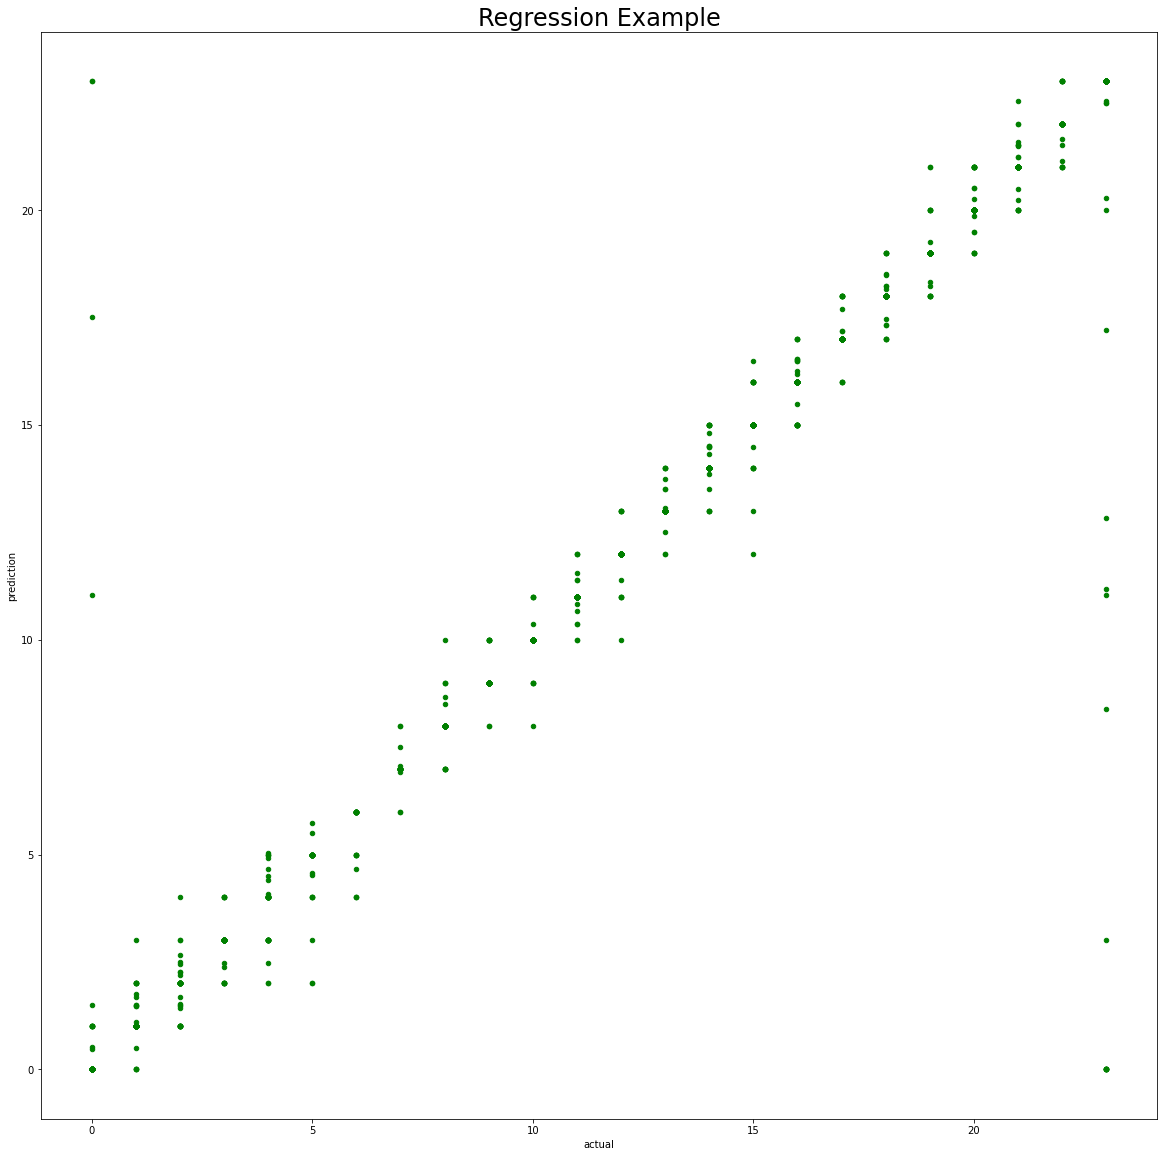

In [31]:
fig, ax = plt.subplots(figsize=(20, 20))
results_df.plot.scatter(x="actual", y="prediction", ax=ax, alpha=1, color='green')
#cluster_gdf.plot(ax=ax, alpha=1, markersize=1, color='blue')
ax.set_title('Regression Example', fontsize=24, loc='center')
#plt.savefig("C:/Users/mhudgell/figures/local.png")
plt.show()